In [3]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install scikit-learn
!pip install torch
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 7.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB
None
                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5


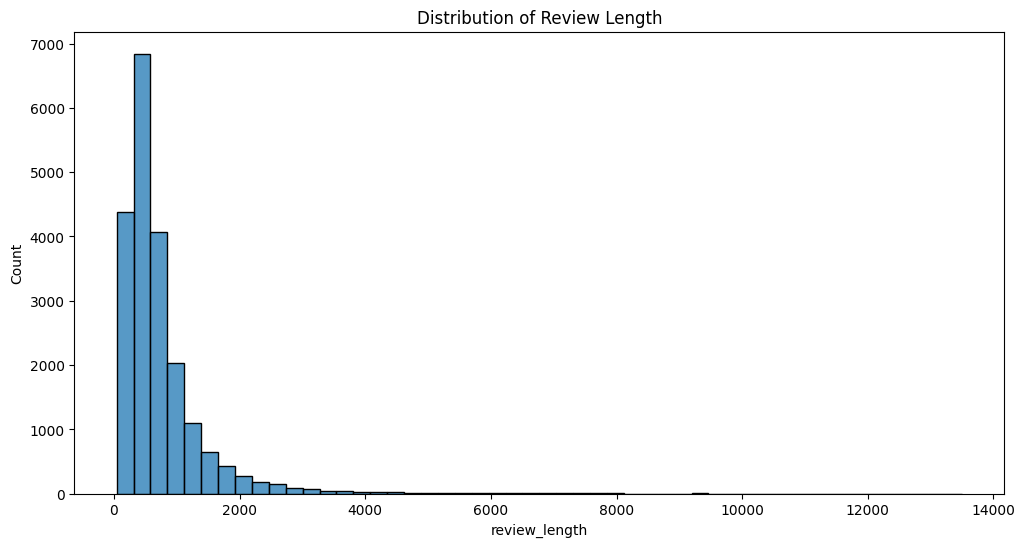

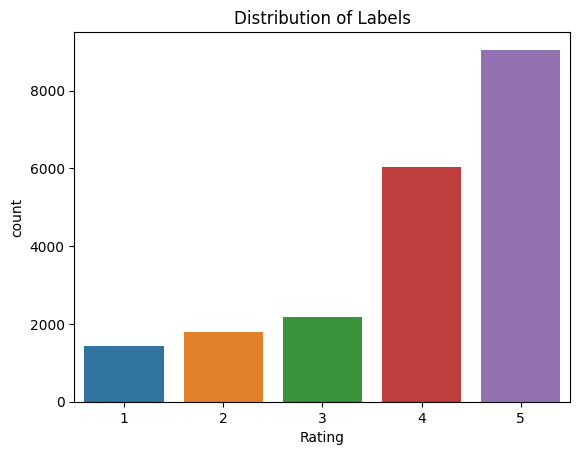

         count        mean         std   min     25%    50%      75%      max
Rating                                                                       
1       1421.0  769.534835  686.927121  77.0  351.00  564.0   943.00   6511.0
2       1793.0  867.002789  744.420751  74.0  433.00  653.0  1028.00   7802.0
3       2184.0  784.664835  743.864505  47.0  370.75  588.0   931.25  13501.0
4       6039.0  745.339957  729.579982  61.0  340.50  539.0   885.00  10062.0
5       9054.0  661.696488  627.032566  44.0  318.00  496.0   784.00  12738.0
                                              Review  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                Preprocessed Reviews  Rating  review_length  
0  nice hotel expens park got good deal

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 1/12:   0%|          | 0/7870 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg

In [ ]:
# This is a sample Python script.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.cuda
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
import emoji
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
# Press Umschalt+F10 to execute it or replace it with your code.
# Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.
csv = True


def preprocess_review(review):
    # Convert all words to lower case
    review = review.lower()

    # Remove all punctuations
    review = review.translate(str.maketrans('', '', string.punctuation))

    # Remove all stop words
    # Tokenize the sentence
    tokens = nltk.word_tokenize(review)
    # Remove stop words
    clean_tokens = [token for token in tokens if not token.lower() in stop_words]
    # Join the tokens back into a sentence
    review = ' '.join(clean_tokens)

    # Removing HTML Tags, URLs and Website Links
    # Removing Website Links
    temp_text = review.split()

    for i in temp_text:
        if i[-4:] == ".com" or i[:4] == "www.":
            temp_text.remove(i)

    review = ' '.join(temp_text)

    # Remove HTML tags
    clean_text = re.sub('<[^<]+?>', '', review)

    # Remove URLs
    clean_text = re.sub(r'http\S+', '', clean_text)

    review = clean_text

    # Remove numbers
    review = re.sub(r'\d+', '', review)

    # Deemojize Emojis
    review = emoji.demojize(review)

    # Remove mentions
    review = re.sub(r'@\w+', '', review)

    # Stemming
    # Tokenize the sentence
    tokens = nltk.word_tokenize(review)

    # Stem the tokens
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Join the stemmed tokens back into a sentence
    review = ' '.join(stemmed_tokens)

    return review
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)
class CBOWDataset(Dataset):

    def __init__(self, context_size, word_to_ix, raw_text=None, preprocessed_data=None):
        if preprocessed_data:
            self.data = preprocessed_data
        else:
            self.data = self._make_context_targets(context_size, raw_text)
        self.word_to_ix = word_to_ix

    def _make_context_targets(self, context_width, raw_text):
        data = []
        for i in range(context_width, len(raw_text) - context_width):
            # Using slicing to get the context words
            context = raw_text[i - context_width:i] + raw_text[i+1:i+1+context_width]
            target = raw_text[i]
            data.append((context, target))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context_words, target_word = self.data[idx]

        # Check if words are in word_to_ix and Convert list of context words to their indices
        context_idxs = torch.tensor([self.word_to_ix.get(w, 0) for w in context_words], dtype=torch.long)
        target_idx = torch.tensor(self.word_to_ix.get(target_word, 0), dtype=torch.long)

        return context_idxs, target_idx
class CBOW(nn.Module):

    def __init__(self, vocab_size, EMBEDDING_DIM, CONTEXT_WIDTH, HIDDEN_DIM, word_to_ix):
        super(CBOW, self).__init__()

        self.word_to_ix = word_to_ix

        # Embedding layer to represent words in a dense form
        self.embeddings = nn.Embedding(vocab_size, EMBEDDING_DIM)

        # The input to this layer is CONTEXT_WIDTH words from the left, and CONTEXT_WIDTH from the right.
        # Each word is represented as an EMBEDDING_DIM sized vector.
        self.linear1 = nn.Linear(CONTEXT_WIDTH * 2 * EMBEDDING_DIM, HIDDEN_DIM)

        # An additional hidden layer for better representation
        self.linear2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.linear3 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.linear4 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)

        # The output layer predicts the central word, so it has vocab_size units
        self.linear5 = nn.Linear(HIDDEN_DIM, vocab_size)

    def forward(self, context_idxs):
        # Embed the words
        embeds = self.embeddings(context_idxs)

        # Flatten the embeddings
        embeds = embeds.view(-1, embeds.size(1) * embeds.size(2))

        # Pass through the layers
        out = F.relu(self.linear1(embeds))
        out = F.relu(self.linear2(out))
        out = F.relu(self.linear3(out))
        out = F.relu(self.linear4(out))
        out = self.linear5(out)

        # Predict the log probabilities of the center word
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

    def train_model(self, epochs, optimizer, train_dataloader, val_dataloader, device):
        loss_function = nn.NLLLoss()
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            self.train()
            total_loss = 0

            # Training loop with progress bar
            pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
            for context_idxs, target_idx in pbar:
                context_idxs, target_idx = context_idxs.to(device), target_idx.to(device)
                self.zero_grad()
                log_probs = self(context_idxs)
                loss = loss_function(log_probs, target_idx)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                # Update the progress bar description
                pbar.set_description(f"Epoch {epoch+1}/{epochs} Loss: {loss.item():.4f}")


            train_losses.append(total_loss/len(train_dataloader))
            print(f"\nEpoch {epoch+1}, Training Loss: {total_loss/len(train_dataloader)}")

            self.eval()
            total_val_loss = 0

            # Validation loop with progress bar
            val_pbar = tqdm(val_dataloader, desc=f"Validating Epoch {epoch+1}/{epochs}")
            with torch.no_grad():
                for context_idxs, target_idx in val_pbar:
                    context_idxs, target_idx = context_idxs.to(device), target_idx.to(device)
                    log_probs = self(context_idxs)
                    loss = loss_function(log_probs, target_idx)
                    total_val_loss += loss.item()

                    # Update the validation progress bar description
                    val_pbar.set_description(f"Validating Epoch {epoch+1}/{epochs} Val Loss: {loss.item():.4f}")

            val_losses.append(total_val_loss/len(val_dataloader))
            print(f"Epoch {epoch+1}, Validation Loss: {total_val_loss/len(val_dataloader)}")
        return train_losses, val_losses
def test_model_cbow2_trip(self, test_dataloader):
    self.eval()
    total_loss = 0
    loss_function = nn.NLLLoss()

    test_pbar = tqdm(test_dataloader, desc="Testing")
    with torch.no_grad():
        for context, target in test_pbar:
            context, target = context.to(device), target.to(device)
            log_probs = self(context)
            loss = loss_function(log_probs, target)
            total_loss += loss.item()

            test_pbar.set_description(f"Testing Loss: {loss.item():.4f}")

    avg_test_loss = total_loss / len(test_dataloader)
    print(f"Average Testing Loss: {avg_test_loss}")
    return avg_test_loss
def get_closest_word(word, net, topn=5):
    word_distance = []
    emb = net.embeddings
    pdist = nn.PairwiseDistance()
    i = word_to_ix[word]
    lookup_tensor_i = torch.tensor([i], dtype=torch.long).to(device)
    v_i = emb(lookup_tensor_i)
    for j in range(len(vocab)):
        if j != i:
            lookup_tensor_j = torch.tensor([j], dtype=torch.long).to(device)
            v_j = emb(lookup_tensor_j)
            word_distance.append((index_to_word[j], float(pdist(v_i, v_j))))
    word_distance.sort(key=lambda x: x[1])
    return word_distance[:topn]
def print_closest_words(query_word, net):
    closest_tuples = get_closest_word(query_word, net)
    closest_words = [word[0] for word in closest_tuples]  # Extract words from the tuples
    print(f'The five closest words to "{query_word}" are: {", ".join(closest_words)}')
# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    torch.manual_seed(1)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    nltk.download('stopwords')
    nltk.download('punkt')
    if csv:
        stop_words = set(stopwords.words('english'))
        df_trip = pd.read_csv("tripadvisor_hotel_reviews.csv")
        # Exploartive Data Analysis
        print(df_trip.info())
        print(df_trip.head())

        df_trip['review_length'] = df_trip['Review'].apply(len)

        plt.figure(figsize=(12, 6))
        sns.histplot(df_trip['review_length'], bins=50)
        plt.title('Distribution of Review Length')
        plt.show()

        df_trip["review_length"].describe()

        sns.countplot(x='Rating', data=df_trip)
        plt.title('Distribution of Labels')
        plt.show()

        print(df_trip.groupby('Rating')['review_length'].describe())
        df_trip["Preprocessed Reviews"] = df_trip["Review"].apply(preprocess_review)
        cols = list(df_trip.columns.values)
        df_trip = df_trip[['Review', 'Preprocessed Reviews', 'Rating', 'review_length']]
        print(df_trip.head())
        raw_text = (' '.join(df_trip["Preprocessed Reviews"])).split()
        vocab = set(raw_text)
        vocab_size = len(vocab)

        word_to_ix = {word: i for i, word in enumerate(vocab)}

        EMBEDDING_DIM = 50
        CONTEXT_WIDTH = 5
        HIDDEN_DIM = 256
        N_EPOCHS = 12

        full_dataset = CBOWDataset(CONTEXT_WIDTH, word_to_ix, raw_text=raw_text)
        # Split the dataset into training, validation, and test sets
        train_data, temp_data = train_test_split(full_dataset.data, test_size=0.75, random_state=42)
        val_data, test_data = train_test_split(temp_data, test_size=0.75, random_state=42)

        # Using the split data to instantiate datasets
        # raw_text is defaulted to None when using preprocessed_data
        train_dataset = CBOWDataset(context_size=CONTEXT_WIDTH, word_to_ix=word_to_ix, preprocessed_data=train_data)
        val_dataset = CBOWDataset(context_size=CONTEXT_WIDTH, word_to_ix=word_to_ix, preprocessed_data=val_data)
        test_dataset = CBOWDataset(context_size=CONTEXT_WIDTH, word_to_ix=word_to_ix, preprocessed_data=test_data)

        # Creating dataloaders for each dataset
        train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
        val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
        test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
        model_cbow2_trip = CBOW(vocab_size, EMBEDDING_DIM, CONTEXT_WIDTH, HIDDEN_DIM, word_to_ix)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model_cbow2_trip.to(device)

        optimizer = torch.optim.Adam(model_cbow2_trip.parameters(), lr=0.001)
        loss_function = nn.NLLLoss()

        train_losses, val_losses = model_cbow2_trip.train_model(N_EPOCHS, optimizer, train_dataloader, val_dataloader, device)
        index_to_word = {index: word for word, index in word_to_ix.items()}
        net = model_cbow2_trip
        print_closest_words("hotel", model_cbow2_trip)
        print_closest_words("room", model_cbow2_trip)
        print_closest_words("staff", model_cbow2_trip)

        print_closest_words("beautiful", model_cbow2_trip)
        print_closest_words("larg", model_cbow2_trip)
        print_closest_words("pleasant", model_cbow2_trip)

        print_closest_words("decorat", model_cbow2_trip)
        print_closest_words("book", model_cbow2_trip)
        print_closest_words("check", model_cbow2_trip)
    else:

        with open(f'scifi.txt') as f:
            scifi_txt = f.read()

        # Splitting the content into sentences using regex
        sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', scifi_txt)

        # Loading the sentences into a dataframe
        df_scifi = pd.DataFrame(sentences, columns=['text'])
        print(df_scifi.info())
        print(df_scifi.head())
        df_scifi['text_length'] = df_scifi['text'].apply(len)

        plt.figure(figsize=(12, 6))
        sns.histplot(df_scifi['text_length'], bins=50, color='red')
        plt.title('Distribution of Review Length')
        plt.show()

# See PyCharm help at https://www.jetbrains.com/help/pycharm/